In [11]:
# %load ../loaders/imports.py
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import time
import pdb

sys.path.append('..')

from utils import gen_covariance, gen_beta2, gen_data

from sklearn.linear_model import lars_path, lasso_path
from sklearn.linear_model.coordinate_descent import _alpha_grid
from sklearn.preprocessing import StandardScaler
from pyuoi.linear_model import UoI_Lasso
from pyuoi.linear_model.lasso import PycLasso

In [ ]:
# Time taken to solve a full regularization path as the number of samples is increased, with fixed n vs. p ratio

In [12]:
def lasso_loss(X, y, lamb, beta):
    
    loss = 1/(2 * y.size) * np.sum((y - X @ beta)**2) + lamb * np.linalg.norm(beta, 1)
    return loss

In [29]:
n_features = [50, 100, 200, 500, 1000, 2000, 5000, 10000]
n_samples = 4 * n_features

n_alphas = 100

sklearn_cd_loss = []
sklearn_lars_loss = []
pycasso_loss = []

sklearn_cd_time = np.zeros(len(n_features))
sklearn_lars_time = np.zeros(len(n_features))
pycasso_time = np.zeros(len(n_features))

nreps = 10

for i, nf in enumerate(n_features):

    tt = time.time()
    sigma = gen_covariance(nf, 0, nf, 1, 0)
    beta = gen_beta2(nf, nf, sparsity = 0.2, betawidth = np.inf)
    X, X_test, y, y_test, ss = gen_data(n_samples[i], nf, kappa = 5, 
                                        covariance = sigma, beta = beta)
    
    X = StandardScaler().fit_transform(X)
    y -= np.mean(y)

    alphas = _alpha_grid(X, y, n_alphas = n_alphas)

    timings = np.zeros(nreps)
    loss = []
    for j in range(nreps):
        t0 = time.time()
        _, coefs, _ = lasso_path(X, y.ravel(), alphas = alphas)
        timings[j] = time.time() - t0
        loss.append(np.array([lasso_loss(X, y.ravel(), alphas[k], coefs[:, k]) for k in range(n_alphas)]))

    loss = np.array(loss)
    sklearn_cd_time[i] = np.mean(timings)
    sklearn_cd_loss.append(np.mean(loss, axis = 0))

    timings = np.zeros(nreps)
    loss = []
    for j in range(nreps):
        t0 = time.time()
        a, _, coefs = lars_path(X, y.ravel(), method='lasso')
        timings[j] = time.time() - t0
        loss.append(np.array([lasso_loss(X, y.ravel(), a[k], coefs[:, k]) for k in range(a.size)]))

    loss = np.array(loss)
    sklearn_lars_time[i] = np.mean(timings)
    sklearn_lars_loss.append(np.mean(loss, axis = 0))

    timings = np.zeros(nreps)
    loss = []
    pyc_solver = PycLasso(fit_intercept=False, alphas = alphas)    
    for j in range(nreps):
        t0 = time.time()
        pyc_solver.fit(X, y.ravel())
        timings[j] = time.time() - t0
        loss.append(np.array([lasso_loss(X, y.ravel(), alphas[k], pyc_solver.coef_[k, :]) 
                              for k in range(alphas.size)]))

    loss = np.array(loss)
    pycasso_time[i] = np.mean(timings)
    pycasso_loss.append(np.mean(loss, axis = 0))
    
    print('Iteration %d: %f s' % (i, time.time() - tt))

Iteration 0: 0.467308 s
Iteration 1: 1.184502 s
Iteration 2: 3.064147 s
Iteration 3: 10.204172 s
Iteration 4: 46.988426 s
Iteration 5: 260.573486 s
Iteration 6: 2018.470436 s
Iteration 7: 9568.750880 s


In [34]:
sklearn_cd_loss[0].shape

(100,)

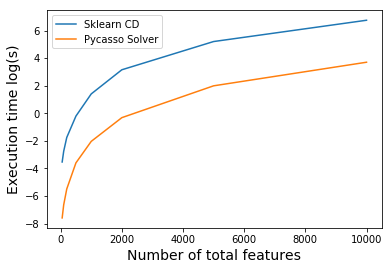

In [48]:
plt.plot(n_features, np.log(sklearn_cd_time))
# plt.plot(n_features, np.log(sklearn_lars_time))
plt.plot(n_features, np.log(pycasso_time))

plt.legend(['Sklearn CD', 'Pycasso Solver'])
plt.ylabel('Execution time log(s)', fontsize = 14)
plt.xlabel('Number of total features', fontsize = 14)
plt.savefig('CDvPyc_time.png')

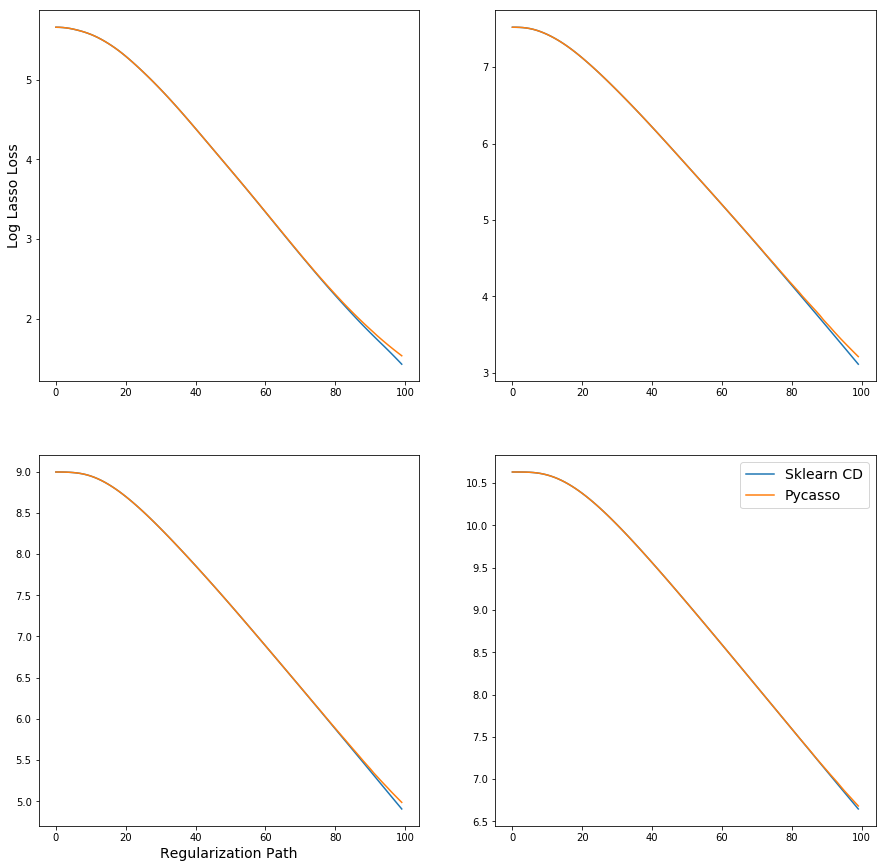

In [49]:
# Plot the attained loss for 4 different feature sizes
fig, ax = plt.subplots(2, 2, figsize = (15, 15))

ax[0, 0].plot(np.log(sklearn_cd_loss[1]))
ax[0, 0].plot(np.log(pycasso_loss[1]))
ax[0, 0].set_ylabel('Log Lasso Loss', fontsize = 14)

ax[0, 1].plot(np.log(sklearn_cd_loss[3]))
ax[0, 1].plot(np.log(pycasso_loss[3]))

ax[1, 0].plot(np.log(sklearn_cd_loss[5]))
ax[1, 0].plot(np.log(pycasso_loss[5]))
ax[1, 0].set_xlabel('Regularization Path', fontsize = 14)

ax[1, 1].plot(np.log(sklearn_cd_loss[7]))
ax[1, 1].plot(np.log(pycasso_loss[7]))

ax[1, 1].legend(['Sklearn CD', 'Pycasso'], fontsize = 14)
plt.savefig('CDvPyc_loss.png')